# Bird Classification Preprocessing

## Problem Statement

Scientists have determined that a known species of bird should be divided into 3 distinct and separate species. These species are endemic to a particular region of the country and their populations must be tracked and estimated with as much precision as possible. As such, a non-profit conservation society has taken up the task. They need to be able to log which species they have encountered based on the characteristics that their field officers observe in the wild. 

Using certain genetic traits and location data, can you predict the species of bird that has been observed?

This is a beginner-level practice competition and your goal is to predict the bird species (A, B, or C) based on attributes or location.

## Import libraries

In [1]:
# Data Management Libraries
import pandas as pd

# Plotting Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# Machine Learning Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

## Helper functions

Define a function for the definition of missing values

In [2]:
def missing_vals(df):
    """prints out columns with perc of missing values"""
    missing = [
        (df.columns[idx], perc)
        for idx, perc in enumerate(df.isna().mean() * 100)
        if perc > 0
    ]

    if len(missing) == 0:
        return "no missing values"
        

    # sort desc by perc
    missing.sort(key=lambda x: x[1], reverse=True)

    print(f"There are a total of {len(missing)} variables with missing values\n")

    for tup in missing:
        print(str.ljust(f"{tup[0]:<20} => {round(tup[1], 3)}%", 1))

## Load data

First we load the train and test data using the `read_csv` function.

We also merge `training_set.csv` (containing the features) with `training_target.csv` (containing the target variable) and form the train data.

In [48]:
train = pd.read_csv("/content/training_set.csv")
labels = pd.read_csv("/content/training_target.csv")

# join target variable to training set
train = train.merge(labels, on="ID")

test = pd.read_csv("/content/test_set.csv")

In [4]:
train.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.300000,48.200000,210.000000,loc_2,4600.0,0.0,284,C
1,14.400000,48.400000,203.000000,loc_2,4625.0,0.0,101,C
2,18.400000,NaN,200.000000,loc_3,3400.0,0.0,400,B
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,98,C
4,18.982114,38.259307,217.186992,loc_3,5200.0,0.0,103,C


Define some columns label for separe numerical from categorical ones.

In [44]:
target_cols = "species"
num_cols = ["bill_depth", "bill_length", "wing_length", "mass"]
cat_cols = ["location", "sex"]
all_cols = num_cols + cat_cols + [target_cols]

train = train[all_cols]

## Exploratory Data Analysis (EDA)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 0 to 434
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_depth   434 non-null    float64
 1   bill_length  295 non-null    float64
 2   wing_length  298 non-null    float64
 3   mass         433 non-null    float64
 4   location     405 non-null    object 
 5   sex          379 non-null    float64
 6   species      435 non-null    object 
dtypes: float64(5), object(2)
memory usage: 27.2+ KB


### Numerical

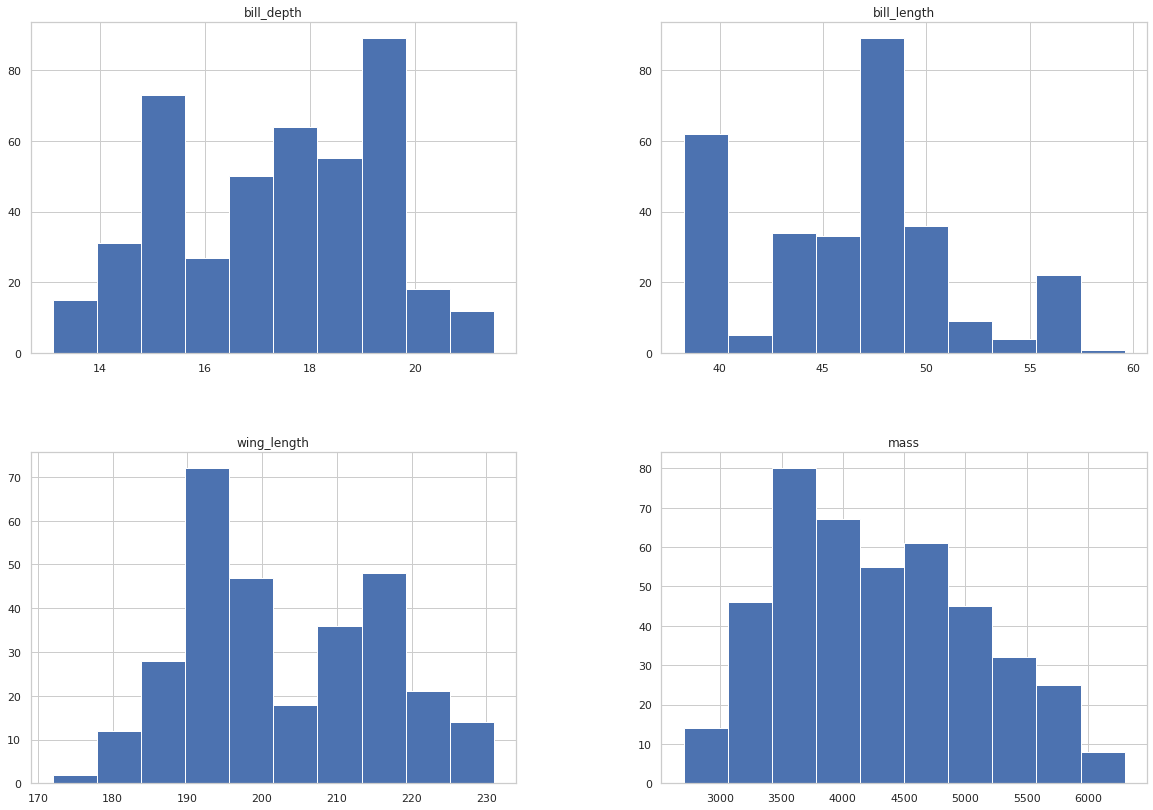

In [7]:
train[num_cols].hist(figsize=(20, 14));

Let's plot the histograms of the numerical variables.

- bill_depth peaks around 15 and 19
- bill length peaks around 39 and 47
- wing length peaks around 190 and 216
- mass is right skewed

### Categorical

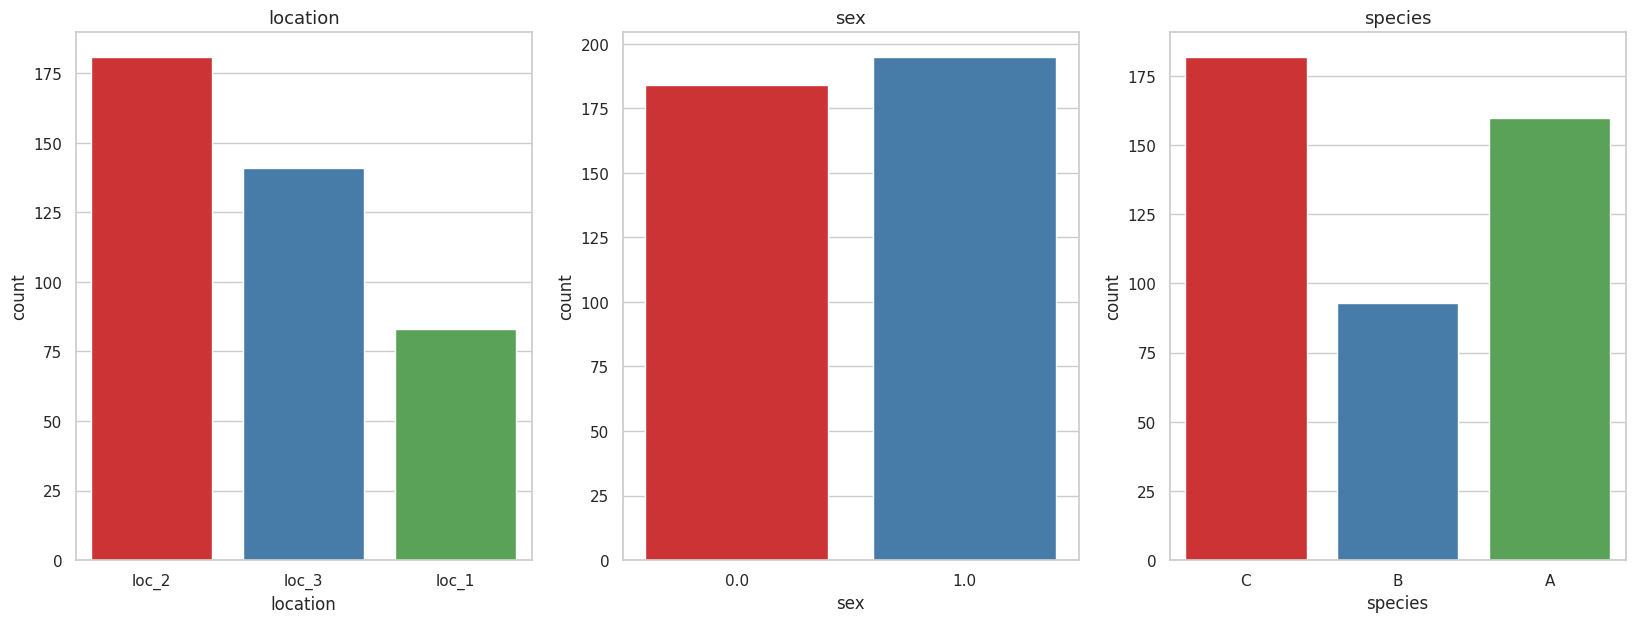

In [8]:
to_plot = cat_cols + [target_cols]
fig, axes = plt.subplots(1, 3, figsize=(20, 7), dpi=100)

for i, col_name in enumerate(train[to_plot].columns):
    sns.countplot(x = col_name, data = train, palette="Set1", ax=axes[i % 3])
    axes[i % 3].set_title(f"{col_name}", fontsize=13)
    plt.subplots_adjust(hspace=0.45)

We see location and species seemingly matches for their respective locations and species (loc2 & species C, loc3 & species A). We also see there are slightly more female (1) birds the male counterpart.

In [9]:
train.species.value_counts()

C    182
A    160
B     93
Name: species, dtype: int64

With a closer look, we see the target variable is imbalanced, where class B is almost 100 class lower than C, and around 70 lower than A.

Imbalanced class is an issue because it biases the model. We need to resolve it later.

## Missing Data

### Percentages of missing values

In [10]:
missing_vals(train)

There are a total of 6 variables with missing values

bill_length          => 32.184%
wing_length          => 31.494%
sex                  => 12.874%
location             => 6.897%
mass                 => 0.46%
bill_depth           => 0.23%


With our helper function, we find out that bill_length and wing_length has over 30% of missing values

### Heatplot

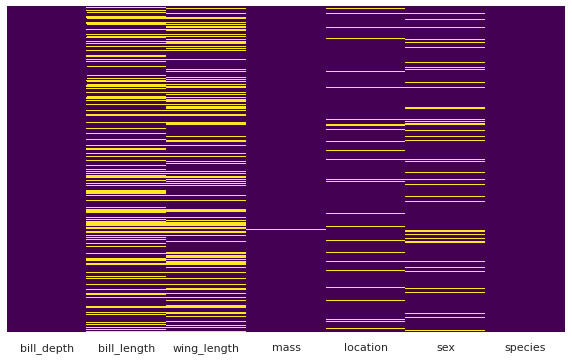

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis', cbar=False);

We can also plot a heatmap to visualize the missing values and see if there are any patterns

### Impute categorical columns

let's first see how many missing variables are in our categorical variables

In [12]:
train.sex.value_counts(dropna=False)

1.0    195
0.0    184
NaN     56
Name: sex, dtype: int64

In [13]:
train.location.value_counts(dropna=False)

loc_2    181
loc_3    141
loc_1     83
NaN       30
Name: location, dtype: int64

Let's use the simple imputer to deal with them by replacing them with the most frequent value.

In [14]:
cat_imp = SimpleImputer(strategy="most_frequent")

train[cat_cols] = cat_imp.fit_transform(train[cat_cols])

In [15]:
train.sex.value_counts(dropna=False)

1.0    251
0.0    184
Name: sex, dtype: int64

As you can see, by the 'most_frequent' strategy, the missing values were imputed with 1.0, which was the most frequent.

### Impute numerical columns

Let's use the median value to impute our numerical values

In [16]:
num_imp = SimpleImputer(strategy="median")

train[num_cols] = num_imp.fit_transform(train[num_cols])

In [17]:
missing_vals(train)

'no missing values'

## Feature Engineering

In [18]:
train.species.value_counts()

C    182
A    160
B     93
Name: species, dtype: int64

### encode categorical variables


Decide to encode the categorical variables into numerical ones beacuse most ML models can't use string values

In [19]:
le = LabelEncoder()
le.fit(train['species'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'A': 0, 'B': 1, 'C': 2}

In [20]:
train['species'] = le.fit_transform(train['species'])

In [21]:
for col in cat_cols:
    if train[col].dtype == "object":
        train[col] = le.fit_transform(train[col])

In [22]:
train.head()

,bill_depth,bill_length,wing_length,mass,location,sex,species
0,14.300000,48.200000,210.000000,4600.0,1,0,2
1,14.400000,48.400000,203.000000,4625.0,1,0,2
2,18.400000,47.500000,200.000000,3400.0,2,0,1
3,14.982114,47.504878,199.000000,4800.0,1,0,2
4,18.982114,38.259307,217.186992,5200.0,2,0,2


In [23]:
# Convert cat_features to pd.Categorical dtype
for col in cat_cols:
    train[col] = pd.Categorical(train[col])

In [24]:
train.dtypes

bill_depth      float64
bill_length     float64
wing_length     float64
mass            float64
location       category
sex            category
species           int64
dtype: object

## Apply Z-score to features

In [25]:
for col in num_cols:
    col_zscore = col + '_zscore'
    train[col_zscore] = (train[col] - train[col].mean())/train[col].std(ddof=0)

train

,bill_depth,bill_length,wing_length,mass,location,sex,species,bill_depth_zscore,bill_length_zscore,wing_length_zscore,mass_zscore
0,14.300000,48.200000,210.000000,4600.0,1,0,2,-1.544327,0.381373,0.756869,0.391531
1,14.400000,48.400000,203.000000,4625.0,1,0,2,-1.492785,0.428951,0.127986,0.423153
2,18.400000,47.500000,200.000000,3400.0,2,0,1,0.568894,0.214851,-0.141535,-1.126323
3,14.982114,47.504878,199.000000,4800.0,1,0,2,-1.192752,0.216012,-0.231375,0.644506
4,18.982114,38.259307,217.186992,5200.0,2,0,2,0.868927,-1.983402,1.402552,1.150458
...,...,...,...,...,...,...,...,...,...,...,...
430,17.000000,48.833824,196.000000,3500.0,1,1,1,-0.152693,0.532153,-0.500897,-0.999835
431,17.100000,47.500000,193.000000,3400.0,2,0,0,-0.101152,0.214851,-0.770418,-1.126323
432,19.400000,47.500000,199.000000,3900.0,0,1,0,1.084314,0.214851,-0.231375,-0.493884
433,16.600000,55.512336,187.000000,2900.0,1,1,1,-0.358861,2.120893,-1.309461,-1.758762


In [26]:
missing_vals(train)

'no missing values'

## Creating new features

Make some data augmentation adding some new features that can help the classifier.

In [27]:
train['b_depth_length_ratio'] = train['bill_depth'] / train['bill_length']
train['b_length_depth_ratio'] = train['bill_length'] / train['bill_depth']
train['w_length_mass_ratio'] = train['wing_length'] / train['mass']

In [28]:
train.head()

,bill_depth,bill_length,wing_length,mass,location,sex,species,bill_depth_zscore,bill_length_zscore,wing_length_zscore,mass_zscore,b_depth_length_ratio,b_length_depth_ratio,w_length_mass_ratio
0,14.300000,48.200000,210.000000,4600.0,1,0,2,-1.544327,0.381373,0.756869,0.391531,0.296680,3.370629,0.045652
1,14.400000,48.400000,203.000000,4625.0,1,0,2,-1.492785,0.428951,0.127986,0.423153,0.297521,3.361111,0.043892
2,18.400000,47.500000,200.000000,3400.0,2,0,1,0.568894,0.214851,-0.141535,-1.126323,0.387368,2.581522,0.058824
3,14.982114,47.504878,199.000000,4800.0,1,0,2,-1.192752,0.216012,-0.231375,0.644506,0.315381,3.170773,0.041458
4,18.982114,38.259307,217.186992,5200.0,2,0,2,0.868927,-1.983402,1.402552,1.150458,0.496144,2.015545,0.041767


In [30]:
trainzscore = train.drop(num_cols, axis=1)
#trainzscore= trainzscore.drop(cat_cols, axis=1)
trainzscore

,location,sex,species,bill_depth_zscore,bill_length_zscore,wing_length_zscore,mass_zscore,b_depth_length_ratio,b_length_depth_ratio,w_length_mass_ratio
0,1,0,2,-1.544327,0.381373,0.756869,0.391531,0.296680,3.370629,0.045652
1,1,0,2,-1.492785,0.428951,0.127986,0.423153,0.297521,3.361111,0.043892
2,2,0,1,0.568894,0.214851,-0.141535,-1.126323,0.387368,2.581522,0.058824
3,1,0,2,-1.192752,0.216012,-0.231375,0.644506,0.315381,3.170773,0.041458
4,2,0,2,0.868927,-1.983402,1.402552,1.150458,0.496144,2.015545,0.041767
...,...,...,...,...,...,...,...,...,...,...
430,1,1,1,-0.152693,0.532153,-0.500897,-0.999835,0.348119,2.872578,0.056000
431,2,0,0,-0.101152,0.214851,-0.770418,-1.126323,0.360000,2.777778,0.056765
432,0,1,0,1.084314,0.214851,-0.231375,-0.493884,0.408421,2.448454,0.051026
433,1,1,1,-0.358861,2.120893,-1.309461,-1.758762,0.299033,3.344117,0.064483


Save the processed dataset into a file in order to use it in Knine.

In [31]:
trainzscore.to_csv('train_zscore.csv',index=False, sep=',')

## Test data

It's necessary to apply the same trasformation also on the test set

In [49]:
num_cols = ["bill_depth", "bill_length", "wing_length", "mass"]
cat_cols = ["location", "sex"]
all_cols = num_cols + cat_cols + [target_cols]

le = LabelEncoder()

cat_imp = SimpleImputer(strategy="most_frequent")
num_imp = SimpleImputer(strategy="median")

test[cat_cols] = cat_imp.fit_transform(test[cat_cols])
test[num_cols] = num_imp.fit_transform(test[num_cols])

for col in cat_cols:
    if test[col].dtype == "object":
        test[col] = le.fit_transform(test[col])

# Convert cat_features to pd.Categorical dtype
for col in cat_cols:
    test[col] = pd.Categorical(test[col])

# save ID column
test_id = test["ID"]

all_cols.remove('species')
test = test[all_cols]

test['b_depth_length_ratio'] = test['bill_depth'] / test['bill_length']
test['b_length_depth_ratio'] = test['bill_length'] / test['bill_depth']
test['w_length_mass_ratio'] = test['wing_length'] / test['mass']

UFuncTypeError: ignored

In [53]:
test2 = test.join(test_id)

test2

,bill_depth,bill_length,wing_length,mass,location,sex,b_depth_length_ratio,b_length_depth_ratio,w_length_mass_ratio,ID
0,14.982114,38.259307,217.186992,5400.0,1,0,0.391594,2.553665,0.040220,2
1,13.200000,46.100000,211.000000,4500.0,1,0,0.286334,3.492424,0.046889,5
2,20.000000,46.750000,197.000000,3300.0,2,1,0.427807,2.337500,0.059697,7
3,17.500000,38.791391,190.000000,3900.0,2,0,0.451131,2.216651,0.048718,8
4,18.900000,46.750000,184.000000,3550.0,1,1,0.404278,2.473545,0.051831,9
...,...,...,...,...,...,...,...,...,...,...
104,19.000000,46.750000,197.000000,3600.0,0,0,0.406417,2.460526,0.054722,507
105,18.000000,46.750000,210.000000,4000.0,0,1,0.385027,2.597222,0.052500,512
106,19.500000,49.000000,210.000000,3950.0,2,1,0.397959,2.512821,0.053165,516
107,17.900000,50.100000,190.000000,3400.0,2,0,0.357285,2.798883,0.055882,533


In [58]:
for col in num_cols:
    col_zscore = col + '_zscore'
    test2[col_zscore] = (test2[col] - test2[col].mean())/test2[col].std(ddof=0)

test3 = test2.drop(num_cols, axis=1)

test3

,location,sex,b_depth_length_ratio,b_length_depth_ratio,w_length_mass_ratio,ID,bill_depth_zscore,bill_length_zscore,wing_length_zscore,mass_zscore
0,1,0,0.391594,2.553665,0.040220,2,-1.217784,-1.927517,1.642621,1.370211
1,1,0,0.286334,3.492424,0.046889,5,-2.132211,-0.047705,1.070085,0.305095
2,2,1,0.427807,2.337500,0.059697,7,1.356964,0.108133,-0.225455,-1.115061
3,2,0,0.451131,2.216651,0.048718,8,0.074179,-1.799950,-0.873226,-0.404983
4,1,1,0.404278,2.473545,0.051831,9,0.792539,0.108133,-1.428457,-0.819195
...,...,...,...,...,...,...,...,...,...,...
104,0,0,0.406417,2.460526,0.054722,507,0.843850,0.108133,-0.225455,-0.760022
105,0,1,0.385027,2.597222,0.052500,512,0.330736,0.108133,0.977547,-0.286637
106,2,1,0.397959,2.512821,0.053165,516,1.100407,0.647572,0.977547,-0.345810
107,2,0,0.357285,2.798883,0.055882,533,0.279425,0.911298,-0.873226,-0.996715


In [59]:
test3.to_csv('test_python.csv', index=False, sep=',')